In [4]:
import cv2
import numpy as np

def remove_coins(img_bgr: np.ndarray,
                 # tweak these HSV bounds if your coins appear slightly darker or lighter
                 lower_coin_hsv=(18, 150, 200),
                 upper_coin_hsv=(30, 255, 255),
                 min_area=200,    # minimum blob area to consider (px²)
                 max_area=5000,   # maximum blob area to consider (px²)
                 inpaint_radius=3 # how far to pull pixels from
                ) -> np.ndarray:
    """
    Remove only the bright, gold coin blobs from an image:
      1) HSV threshold on a tight gold range
      2) Morphological clean
      3) Connected‐component area filter (keep only coin‐sized blobs)
      4) Inpaint those regions
    """
    # 1) HSV threshold
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv,
                       np.array(lower_coin_hsv, dtype=np.uint8),
                       np.array(upper_coin_hsv, dtype=np.uint8))

    # 2) Morphological clean (remove speckles / small holes)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    # 3) Keep only components in [min_area, max_area]
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    coin_mask = np.zeros_like(mask)
    for i in range(1, num_labels):  # skip background=0
        area = stats[i, cv2.CC_STAT_AREA]
        if min_area <= area <= max_area:
            coin_mask[labels == i] = 255

    # optional: dilate a little so edges get fully covered
    coin_mask = cv2.dilate(coin_mask,
                           cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)),
                           iterations=1)

    # 4) Inpaint just the coin regions
    result = cv2.inpaint(img_bgr, coin_mask, inpaint_radius, flags=cv2.INPAINT_TELEA)
    return result


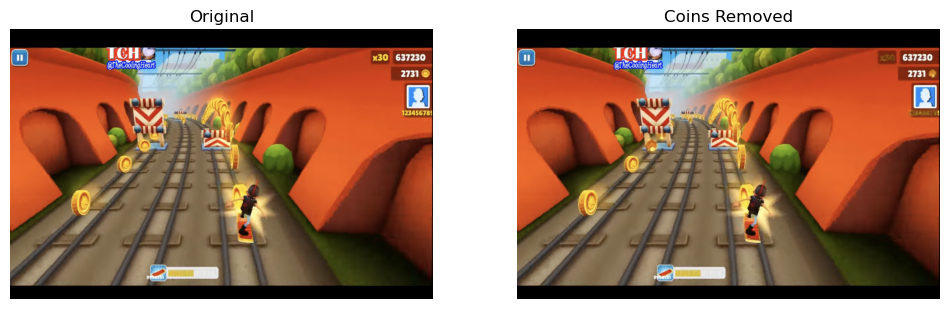

In [5]:
import matplotlib.pyplot as plt

if __name__ == "__main__":
    img = cv2.imread("test2.png")    # your screenshot
    cleaned = remove_coins(img)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.title("Original");  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));  plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Coins Removed");  plt.imshow(cv2.cvtColor(cleaned, cv2.COLOR_BGR2RGB));  plt.axis("off")
    plt.show()


In [8]:
import cv2
import numpy as np

def remove_coins_hough(
    img_bgr: np.ndarray,
    # HSV range tuned for bright gold coins
    lower_yellow_hsv=(15, 100, 100),
    upper_yellow_hsv=(40, 255, 255),
    # HoughCircles parameters
    dp=1.2,
    min_dist=30,
    param1=50,
    param2=20,
    min_radius=10,
    max_radius=60,
    # how much to dilate the coin mask before inpainting
    dilate_iter=2,
    inpaint_radius=3
) -> np.ndarray:
    """
    Remove circular yellow coins from an image using HSV + HoughCircles + inpainting.
    """
    # 1) Threshold yellow in HSV
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    mask_yellow = cv2.inRange(
        hsv,
        np.array(lower_yellow_hsv, dtype=np.uint8),
        np.array(upper_yellow_hsv, dtype=np.uint8)
    )
    # Clean tiny specks
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_OPEN,  kernel, iterations=1)
    mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_CLOSE, kernel, iterations=1)

    # 2) Prepare grayscale for Hough (masked)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray_masked = cv2.bitwise_and(gray, gray, mask=mask_yellow)

    # 3) Detect circles in the yellow regions
    circles = cv2.HoughCircles(
        gray_masked,
        cv2.HOUGH_GRADIENT,
        dp=dp,
        minDist=min_dist,
        param1=param1,
        param2=param2,
        minRadius=min_radius,
        maxRadius=max_radius
    )

    # 4) Build coin mask from those circles
    coin_mask = np.zeros_like(gray)
    if circles is not None:
        for x, y, r in np.uint16(np.around(circles[0])):
            cv2.circle(coin_mask, (x, y), r + 2, 255, thickness=-1)

    # 5) (Optional) Dilate a bit so edges get covered
    if dilate_iter > 0:
        coin_mask = cv2.dilate(
            coin_mask,
            cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)),
            iterations=dilate_iter
        )

    # 6) Inpaint only those circular regions
    result = cv2.inpaint(img_bgr, coin_mask, inpaint_radius, flags=cv2.INPAINT_TELEA)
    return result


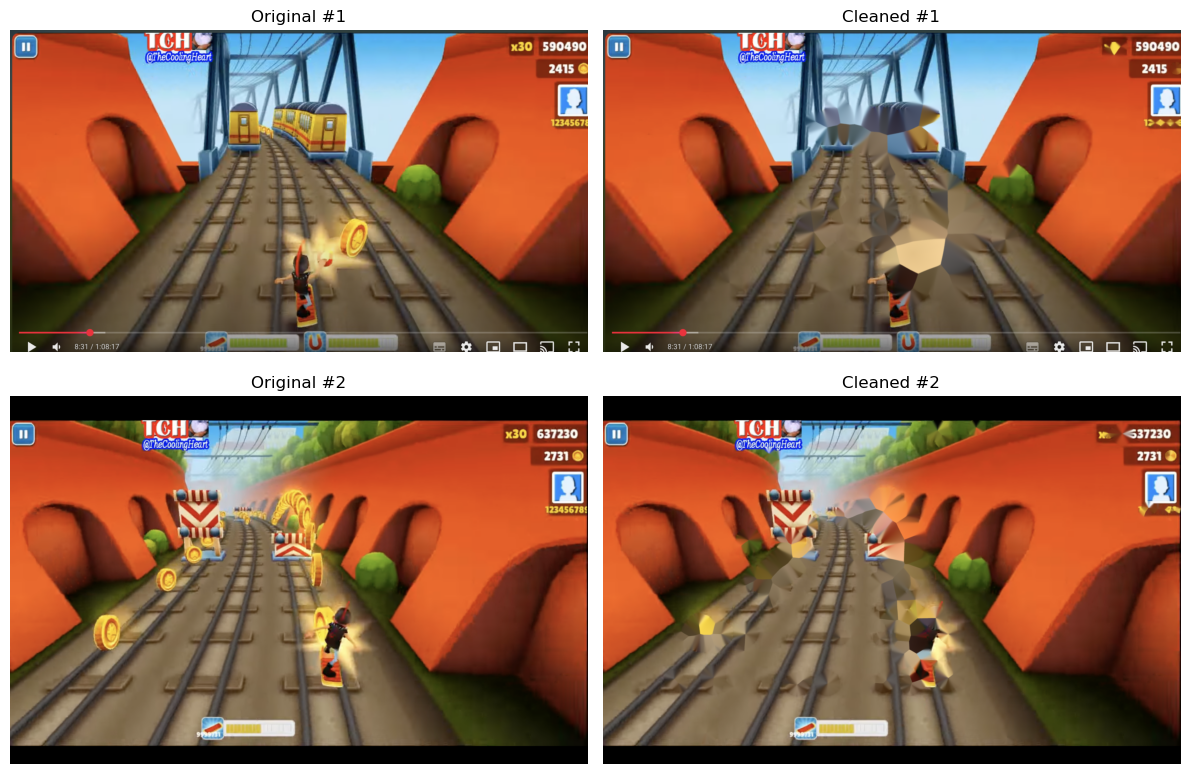

In [10]:
import matplotlib.pyplot as plt

img = cv2.imread("test1.png")  # your first frame
clean1 = remove_coins_hough(img)

img2 = cv2.imread("test2.png")  # your second frame
clean2 = remove_coins_hough(img2)

# display results
fig, axes = plt.subplots(2, 2, figsize=(12,8))
for ax, im, title in [
    (axes[0,0], img,   "Original #1"),
    (axes[0,1], clean1,"Cleaned #1"),
    (axes[1,0], img2,  "Original #2"),
    (axes[1,1], clean2,"Cleaned #2"),
]:
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    ax.set_title(title); ax.axis("off")
plt.tight_layout()
plt.show()


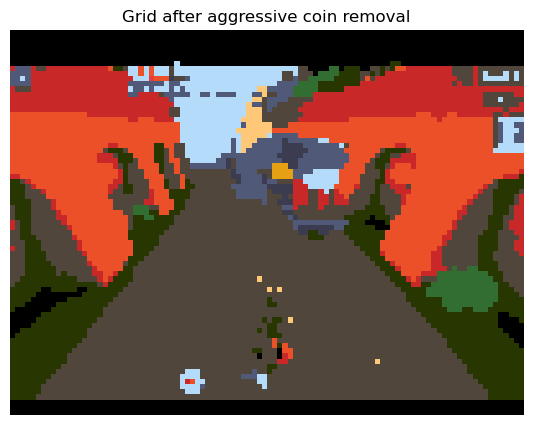

In [11]:
import cv2
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# 1) Configuration
IMG_PATH   = "test3.png"
GRID_W, GRID_H = 100, 75

PALETTE = {
    (180, 220, 250): 0,   # Sky
    (145,  90,  55): 1,   # Ground
    ( 80,   70,  60): 1,   # Rails
    (235,  60,  60): 2,   # Barrier
    (200,  40,  40): 3,   # Barrier shadow
    (255, 215,   0): 4,   # Coin (we’ll mask this out)
    (255, 200, 120): 5,   # Glow
    (255, 230,  90): 6,   # Train highlight
    (245, 190,  30): 7,   # Train mid
    (230, 160,  20): 8,   # Train shadow
    ( 80,   90, 120): 9,   # Metal
    ( 60,   60,  80):10,   # Bridge
    (235,  80,  40):11,   # Wall
    ( 40,   54,   1):12,   # Bush dark
    ( 50,  110,  50):13,   # Bush light
    (  0,    0,    0):14,  # Fallback
}

def nearest_color_label(rgb, palette):
    best_key, best_dist = None, float("inf")
    for key, label in palette.items():
        if len(key) != 3: continue
        d = sum((int(rgb[i]) - key[i])**2 for i in range(3))
        if d < best_dist:
            best_dist, best_key = d, key
    return palette[best_key]

# --- STEP A: Aggressive inpainting to remove coins ---

# Load BGR image
img_bgr = cv2.imread(IMG_PATH)
h_img, w_img = img_bgr.shape[:2]

# Convert to HSV and threshold for gold/yellow
hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
lower = np.array((20, 100, 100))
upper = np.array((40, 255, 255))
mask  = cv2.inRange(hsv, lower, upper)

# Dilate heavily so we wipe out even glow and fringes
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=3)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  kernel, iterations=2)
mask = cv2.dilate(mask, kernel, iterations=5)

# Inpaint with Navier–Stokes (stronger fill)
img_bgr = cv2.inpaint(img_bgr, mask, inpaintRadius=10, flags=cv2.INPAINT_NS)

# Convert back to RGB for classification
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# --- STEP B: Build grid ---

cell_w = w_img // GRID_W
cell_h = h_img // GRID_H
grid  = np.zeros((GRID_H, GRID_W), dtype=np.int32)

for row in range(GRID_H):
    for col in range(GRID_W):
        x0, y0 = col*cell_w, row*cell_h
        x1, y1 = x0+cell_w, y0+cell_h
        cell = img[y0:y1, x0:x1]

        # classify each pixel then drop any coin-label (4)
        pixels = cell.reshape(-1, 3)
        labs   = [nearest_color_label(tuple(rgb), PALETTE) for rgb in pixels]
        non4   = [l for l in labs if l != 4]

        grid[row, col] = Counter(non4).most_common(1)[0][0] if non4 else 1

# --- STEP C: Visualize ---

color_map = {v: tuple(c/255 for c in k) for k,v in PALETTE.items()}
vis = np.zeros((*grid.shape, 3))
for lab, col in color_map.items():
    vis[grid==lab] = col

plt.figure(figsize=(8,5))
plt.imshow(vis, interpolation='nearest')
plt.axis('off')
plt.title("Grid after aggressive coin removal")
plt.show()
